# Simple "Vanilla" GAN (in Keras)
---
Student: Pablo Javier de Paz Carbajo <br>

More info about me: https://www.linkedin.com/in/pablodepaz/

Python Notebook belonging to the Final Year Project **"A review on Generative Adversarial Networks for unsupervised Machine Learning"** done in _Universidad Carlos III de Madrid_ and presented in June 2019.

---


First of all, import **Keras**, an open-source neural network library for Python, and _matplotlib_ for plotting the digits. In addition, import some Keras’ components that will be used later on and _numpy_.

In [1]:
import keras
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from tqdm import tqdm

import numpy as np

Using TensorFlow backend.


Next, the random noise vector will always have the same dimension:

In [0]:
np.random.seed(1000)

#Set the dimension of a random noise vector
random_dim = 100

I shall use the popular MNIST dataset which contains images (28x28) of digits from 0–9. <br>
It has a **training set of 60,000 examples** and a **test set of 10,000 examples**.

This dataset is available with Keras and can be imported as <pre>mnist.load_data()</pre>

After, I create a function to import the database (MNIST), normalize the inputs and resize the x_train matrix to a 2D one

In [0]:
def load_minst_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    #Normalize    
    x_train = (x_train.astype(np.float32)-127.5)/127.5
    
    #Reshapes x_train
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

------

For the **discriminator** and **generator** neural networks, both an optimizer and an activation function are needed. 
- For the first one, I am using ADAM’s optimizer. It achieves good results very quickly by computing gradient descent. 
- Regarding the activation function of G, I use the Hyperbolic Tangent because it ranges (-1,1) unlike the Sigmoid function which ranges (0,1). For D, a special type of ramp function called _Leaky ReLU_. This function is mainly defined for the positive part of its input, x, and allows a small, positive gradient when the unit is not active, x<0.

![](https://i.ibb.co/v1C1jpV/Captura-de-pantalla-2019-05-31-a-las-19-18-00.png "Formula")

![](https://i.ibb.co/khjtkc9/Captura-de-pantalla-2019-05-31-a-las-19-18-09.png "Leaky ReLU")

I use the ```Adam optimizer``` in both networks. 


In [4]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


-----
#Discriminator and Generator

Let's create the **generator** and **discriminator networks**. 

Note: add dropout layers to prevent overfitting.

###Generator

In [0]:
generator = Sequential()

#Input layer
generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))

#Hidden layer
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))

#Hidden layer
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))

#Output layer
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

---
###Discriminator

In [6]:
discriminator = Sequential()

#Input layer
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3)) 

#Hidden layer
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

#Hidden layer
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

#Output layer
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


---

###GAN setup
Now that we have the discriminator and the generator, should you combine them. 

Since I want to train only one network at a time, we set trainable to False.

In [0]:
discriminator.trainable = False
ganInput = Input(shape=(random_dim,))

#GAN
x = generator(ganInput)
ganOutput = discriminator(x)

gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

---

###Useful Python functions
I dedicated this section to create a set of funcions that are complementary to the training of the GAN but very useful for data visualization and metrics.

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('image_generated_%d.png' % epoch)

In [0]:
def show_graphs_analytics(d_loss_total,g_loss_total,x_axis_epochs,epochs):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(x_axis_epochs,d_loss_total)
    z1 = np.polyfit(x_axis_epochs, d_loss_total, 2)
    p1 = np.poly1d(z1)
    plt.plot(x_axis_epochs,p1(x_axis_epochs),'r--')
    plt.title('Metrics for "Simple GAN in Keras"')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('D Loss')

    plt.subplot(2, 1, 2)
    plt.plot(x_axis_epochs,g_loss_total)
    z2 = np.polyfit(x_axis_epochs, g_loss_total, 2)
    p2 = np.poly1d(z2)
    plt.plot(x_axis_epochs,p2(x_axis_epochs),'r--')   
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('G Loss')
    plt.savefig('losses_%d.png' % epochs)
    
    plt.show()

In [0]:
def analytics_losses(d_loss_total,g_loss_total,epochs):
  #Only if the number of epochs is >500, do analysis
  #Take the last 250 elements of Losses for the analysis
  
  index_to_start = epochs - 250
  
  d_loss_last_elements = d_loss_total[index_to_start:]
  d_loss_average = np.mean(d_loss_last_elements)
    
  g_loss_last_elements = g_loss_total[index_to_start:]
  g_loss_last_elements = g_loss_total
  g_loss_average = np.mean(g_loss_last_elements)
  
  #Now, save it to .txt
  filename = 'analytics_losses' + str(epochs) + '.txt'
  data = "Epochs: " + str(epochs) + "\n"
  data += "d_loss_average: " + str(d_loss_average) + "\n"
  data += "g_loss_average: " + str(g_loss_average)
    
  text_file = open(filename, "w")
  text_file.write(data)
  text_file.close()

In [0]:
def save_to_txt(d_loss_total,g_loss_total,epochs):
  filename1 = 'd_loss_' + str(epochs) + '.txt'
  np.savetxt(filename1, d_loss_total, delimiter=',') 
  
  filename2 = 'g_loss_' + str(epochs) + '.txt'
  np.savetxt(filename2, g_loss_total, delimiter=',') 

---
###Training

In [0]:
def train(epochs=1, batch_size=128):
    x_train, y_train, x_test, y_test = load_minst_data()
    
    batch_count = x_train.shape[0] / batch_size
    
    x_axis_epochs = np.arange(1, epochs+1, 1)
    d_loss_total = []
    acc_d_total = []
    acc_g_total = []
    g_loss_total = []
    
    for e in range(1, epochs+1):
        print('-'*10, 'Epoch %d' % e, '-'*10)        

        for _ in tqdm(range(int(batch_count))):
            
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            generated_images = generator.predict(noise)
            
            X = np.concatenate([image_batch, generated_images])
            
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            
            #Train the discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
          
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            
            y_gen = np.ones(batch_size)
            
            discriminator.trainable = False
            
            #Train the generator
            (g_loss, acc_g_FromTrainOnBatch) = gan.train_on_batch(noise, y_gen)
            
      
        d_loss_total.append(d_loss)
        g_loss_total.append(g_loss)
    
    show_graphs_analytics(d_loss_total,g_loss_total,x_axis_epochs,epochs)
    
    if(epochs > 500):
      analytics_losses(d_loss_total,g_loss_total,epochs)
      
    save_to_txt(d_loss_total,g_loss_total,epochs)
    plot_generated_images(e, generator)

Choose the number of iterations (epochs) you wish. Normally, the more iterations the better results but the longer it takes to run.

11493376/11490434 [==============================] - 2s 0us/step


  0%|          | 0/468 [00:00<?, ?it/s]

---------- Epoch 1 ----------
Instructions for updating:
Use tf.cast instead.


  2%|▏         | 8/468 [00:00<00:05, 77.80it/s]

---------- Epoch 2 ----------


  2%|▏         | 8/468 [00:00<00:06, 72.48it/s]

---------- Epoch 3 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.19it/s]

---------- Epoch 4 ----------


  2%|▏         | 8/468 [00:00<00:05, 77.50it/s]

---------- Epoch 5 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.45it/s]

---------- Epoch 6 ----------


  2%|▏         | 8/468 [00:00<00:06, 75.33it/s]

---------- Epoch 7 ----------


  2%|▏         | 8/468 [00:00<00:06, 75.34it/s]

---------- Epoch 8 ----------


  2%|▏         | 8/468 [00:00<00:06, 71.49it/s]

---------- Epoch 9 ----------


  1%|▏         | 7/468 [00:00<00:06, 68.42it/s]

---------- Epoch 10 ----------


  2%|▏         | 8/468 [00:00<00:06, 74.09it/s]

---------- Epoch 11 ----------


  2%|▏         | 8/468 [00:00<00:06, 75.22it/s]

---------- Epoch 12 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.94it/s]

---------- Epoch 13 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.78it/s]

---------- Epoch 14 ----------


  2%|▏         | 8/468 [00:00<00:05, 76.79it/s]

---------- Epoch 15 ----------


  2%|▏         | 8/468 [00:00<00:06, 72.28it/s]

---------- Epoch 16 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.15it/s]

---------- Epoch 17 ----------


  2%|▏         | 8/468 [00:00<00:06, 73.60it/s]

---------- Epoch 18 ----------


  1%|▏         | 7/468 [00:00<00:06, 66.13it/s]

---------- Epoch 19 ----------


  1%|▏         | 7/468 [00:00<00:07, 65.38it/s]

---------- Epoch 20 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.65it/s]

---------- Epoch 21 ----------


  2%|▏         | 8/468 [00:00<00:06, 71.06it/s]

---------- Epoch 22 ----------


  2%|▏         | 8/468 [00:00<00:05, 76.83it/s]

---------- Epoch 23 ----------


  2%|▏         | 8/468 [00:00<00:05, 77.74it/s]

---------- Epoch 24 ----------


  2%|▏         | 8/468 [00:00<00:06, 75.44it/s]

---------- Epoch 25 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.84it/s]

---------- Epoch 26 ----------


  2%|▏         | 8/468 [00:00<00:06, 71.90it/s]

---------- Epoch 27 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.00it/s]

---------- Epoch 28 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.57it/s]

---------- Epoch 29 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.21it/s]

---------- Epoch 30 ----------


  2%|▏         | 9/468 [00:00<00:05, 81.09it/s]

---------- Epoch 31 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.85it/s]

---------- Epoch 32 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.77it/s]

---------- Epoch 33 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.14it/s]

---------- Epoch 34 ----------


  1%|▏         | 7/468 [00:00<00:07, 64.33it/s]

---------- Epoch 35 ----------


  1%|▏         | 7/468 [00:00<00:06, 69.56it/s]

---------- Epoch 36 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.95it/s]

---------- Epoch 37 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.18it/s]

---------- Epoch 38 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.91it/s]

---------- Epoch 39 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.48it/s]

---------- Epoch 40 ----------


  2%|▏         | 8/468 [00:00<00:06, 73.40it/s]

---------- Epoch 41 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.61it/s]

---------- Epoch 42 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.26it/s]

---------- Epoch 43 ----------


  1%|▏         | 7/468 [00:00<00:07, 63.99it/s]

---------- Epoch 44 ----------


  1%|▏         | 7/468 [00:00<00:06, 68.55it/s]

---------- Epoch 45 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.77it/s]

---------- Epoch 46 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.42it/s]

---------- Epoch 47 ----------


  2%|▏         | 8/468 [00:00<00:06, 71.28it/s]

---------- Epoch 48 ----------


  2%|▏         | 8/468 [00:00<00:06, 69.95it/s]

---------- Epoch 49 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.09it/s]

---------- Epoch 50 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.45it/s]

---------- Epoch 51 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.92it/s]

---------- Epoch 52 ----------


  2%|▏         | 8/468 [00:00<00:06, 71.53it/s]

---------- Epoch 53 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.11it/s]

---------- Epoch 54 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.68it/s]

---------- Epoch 55 ----------


  2%|▏         | 9/468 [00:00<00:05, 80.46it/s]

---------- Epoch 56 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.60it/s]

---------- Epoch 57 ----------


  2%|▏         | 9/468 [00:00<00:05, 80.13it/s]

---------- Epoch 58 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.03it/s]

---------- Epoch 59 ----------


  2%|▏         | 9/468 [00:00<00:05, 80.38it/s]

---------- Epoch 60 ----------


  2%|▏         | 8/468 [00:00<00:06, 72.26it/s]

---------- Epoch 61 ----------


  2%|▏         | 8/468 [00:00<00:06, 70.73it/s]

---------- Epoch 62 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.90it/s]

---------- Epoch 63 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.91it/s]

---------- Epoch 64 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.84it/s]

---------- Epoch 65 ----------


  2%|▏         | 9/468 [00:00<00:05, 81.09it/s]

---------- Epoch 66 ----------


  2%|▏         | 8/468 [00:00<00:05, 77.97it/s]

---------- Epoch 67 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.65it/s]

---------- Epoch 68 ----------


  2%|▏         | 9/468 [00:00<00:05, 80.49it/s]

---------- Epoch 69 ----------


  1%|▏         | 7/468 [00:00<00:07, 65.67it/s]

---------- Epoch 70 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.00it/s]

---------- Epoch 71 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.66it/s]

---------- Epoch 72 ----------


  2%|▏         | 8/468 [00:00<00:06, 76.50it/s]

---------- Epoch 73 ----------


  2%|▏         | 8/468 [00:00<00:06, 71.60it/s]

---------- Epoch 74 ----------


  1%|▏         | 7/468 [00:00<00:06, 69.92it/s]

---------- Epoch 75 ----------


  2%|▏         | 8/468 [00:00<00:06, 76.60it/s]

---------- Epoch 76 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.52it/s]

---------- Epoch 77 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.42it/s]

---------- Epoch 78 ----------


  2%|▏         | 9/468 [00:00<00:05, 80.33it/s]

---------- Epoch 79 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.28it/s]

---------- Epoch 80 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.43it/s]

---------- Epoch 81 ----------


  2%|▏         | 9/468 [00:00<00:05, 80.24it/s]

---------- Epoch 82 ----------


  1%|▏         | 7/468 [00:00<00:06, 67.68it/s]

---------- Epoch 83 ----------


  2%|▏         | 8/468 [00:00<00:06, 71.57it/s]

---------- Epoch 84 ----------


  2%|▏         | 9/468 [00:00<00:05, 80.35it/s]

---------- Epoch 85 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.32it/s]

---------- Epoch 86 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.88it/s]

---------- Epoch 87 ----------


  2%|▏         | 8/468 [00:00<00:06, 68.10it/s]

---------- Epoch 88 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.40it/s]

---------- Epoch 89 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.85it/s]

---------- Epoch 90 ----------


  2%|▏         | 8/468 [00:00<00:06, 73.20it/s]

---------- Epoch 91 ----------


  2%|▏         | 8/468 [00:00<00:06, 74.10it/s]

---------- Epoch 92 ----------


  2%|▏         | 8/468 [00:00<00:05, 78.25it/s]

---------- Epoch 93 ----------


  1%|▏         | 7/468 [00:00<00:06, 69.04it/s]

---------- Epoch 94 ----------


  2%|▏         | 8/468 [00:00<00:06, 73.15it/s]

---------- Epoch 95 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.03it/s]

---------- Epoch 96 ----------


  2%|▏         | 8/468 [00:00<00:06, 75.17it/s]

---------- Epoch 97 ----------


  2%|▏         | 8/468 [00:00<00:05, 79.97it/s]

---------- Epoch 98 ----------


  2%|▏         | 8/468 [00:00<00:05, 77.40it/s]

---------- Epoch 99 ----------


  2%|▏         | 9/468 [00:00<00:05, 81.00it/s]

---------- Epoch 100 ----------


100%|██████████| 468/468 [00:06<00:00, 69.09it/s]


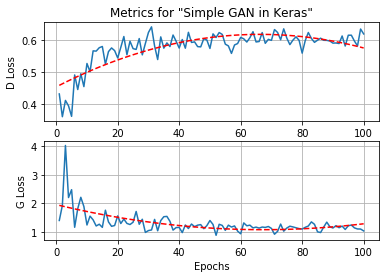

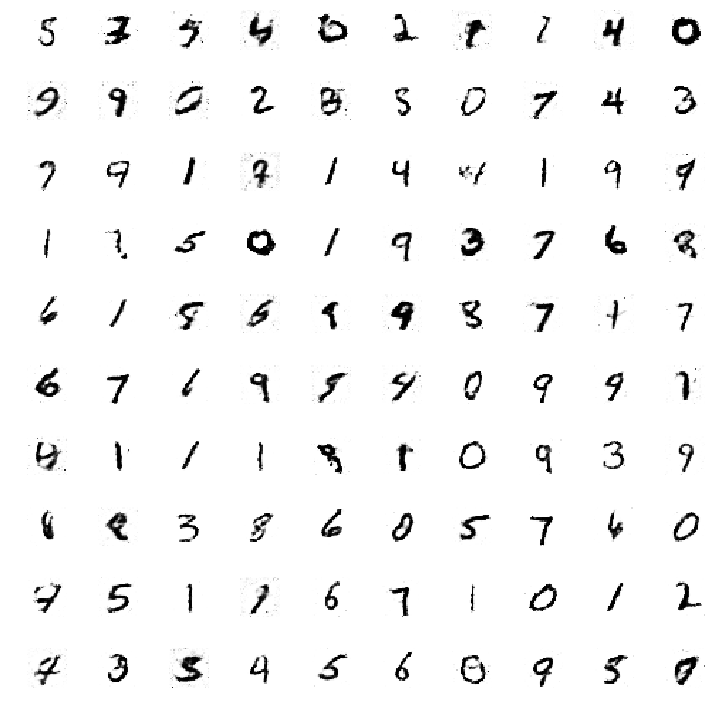

In [13]:
num_epochs = 100
batch_size = 128
train(num_epochs, batch_size)